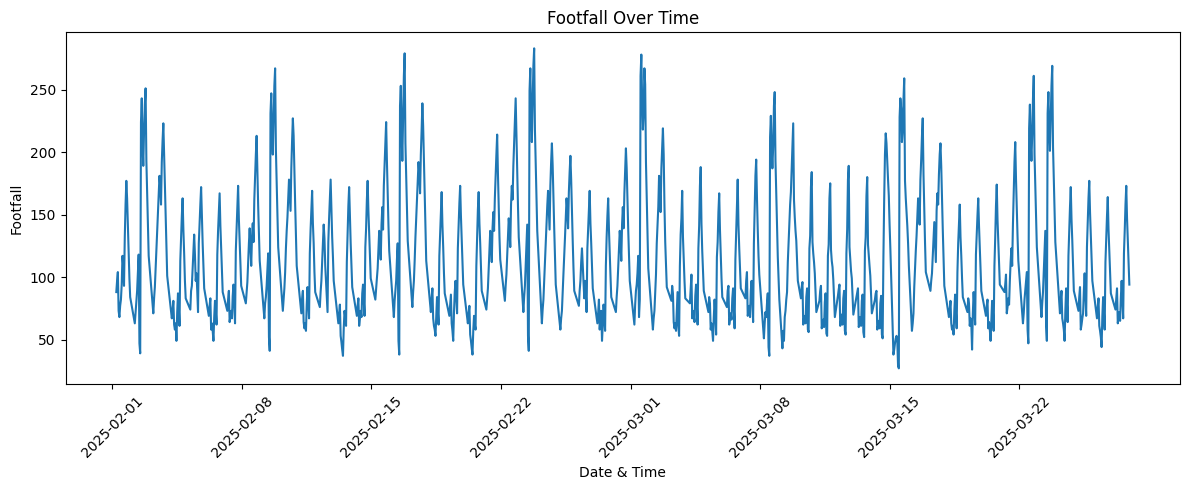

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Update this path if needed
file_path = r"C:\Users\zaidb\Downloads\footfall_data (4).csv"

# Load the data, parsing the “datetime” column (day‑first format)
df = pd.read_csv(
    file_path,
    parse_dates=['datetime'],
    dayfirst=True
)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(df['datetime'], df['footfall'])
plt.xlabel('Date & Time')
plt.ylabel('Footfall')
plt.title('Footfall Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


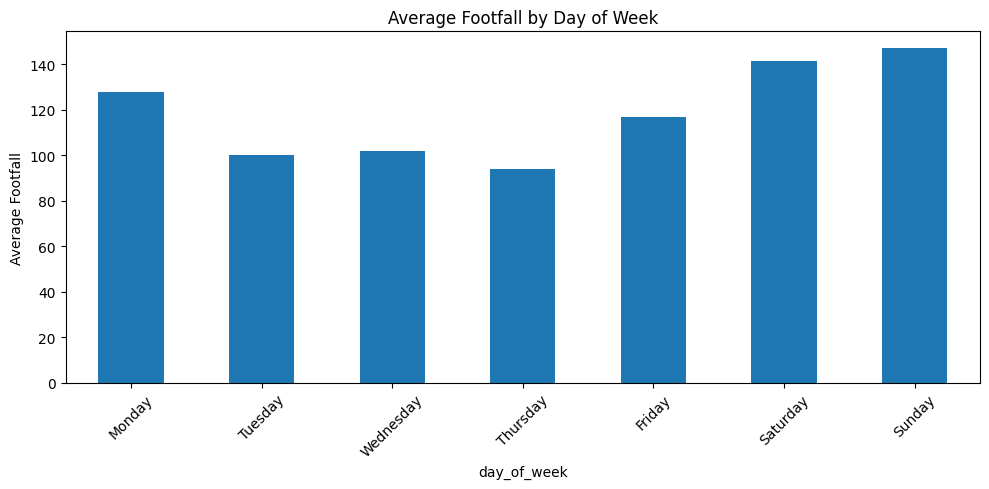

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = r"C:\Users\zaidb\Downloads\footfall_data (4).csv"

# Load and parse datetime
df = pd.read_csv(file_path, parse_dates=['datetime'], dayfirst=True)

# Extract weekday (0=Mon, …,6=Sun)
df['day_of_week'] = df['datetime'].dt.dayofweek

# Compute average footfall per weekday
avg_footfall = df.groupby('day_of_week')['footfall'].mean()

# Plot
plt.figure(figsize=(10,5))
avg_footfall.plot(kind='bar')
plt.xticks(ticks=range(7), labels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], rotation=45)
plt.ylabel('Average Footfall')
plt.title('Average Footfall by Day of Week')
plt.tight_layout()
plt.show()


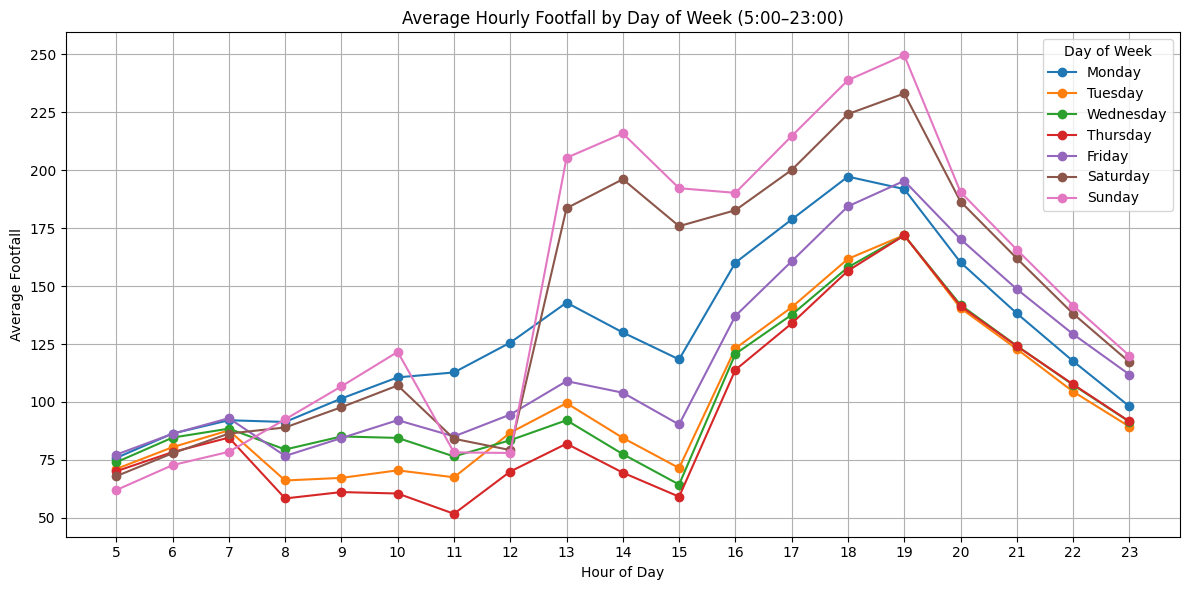

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# File path
file_path = r"C:\Users\zaidb\Downloads\footfall_data (4).csv"

# Load & parse datetime
df = pd.read_csv(file_path, parse_dates=['datetime'], dayfirst=True)

# Extract day‑of‑week (0=Mon…6=Sun) and hour
df['day_of_week'] = df['datetime'].dt.dayofweek
df['hour'] = df['datetime'].dt.hour

# Filter to hours 5–23
df = df[df['hour'].between(5, 23)]

# Compute average footfall for each (hour, day_of_week)
avg = df.groupby(['hour', 'day_of_week'])['footfall'].mean().unstack()

# Plot one line per weekday
plt.figure(figsize=(12, 6))
weekday_names = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
for dow in range(7):
    plt.plot(avg.index, avg[dow], marker='o', label=weekday_names[dow])

plt.xticks(range(5, 24))
plt.xlabel('Hour of Day')
plt.ylabel('Average Footfall')
plt.title('Average Hourly Footfall by Day of Week (5:00–23:00)')
plt.legend(title='Day of Week')
plt.grid(True)
plt.tight_layout()
plt.show()


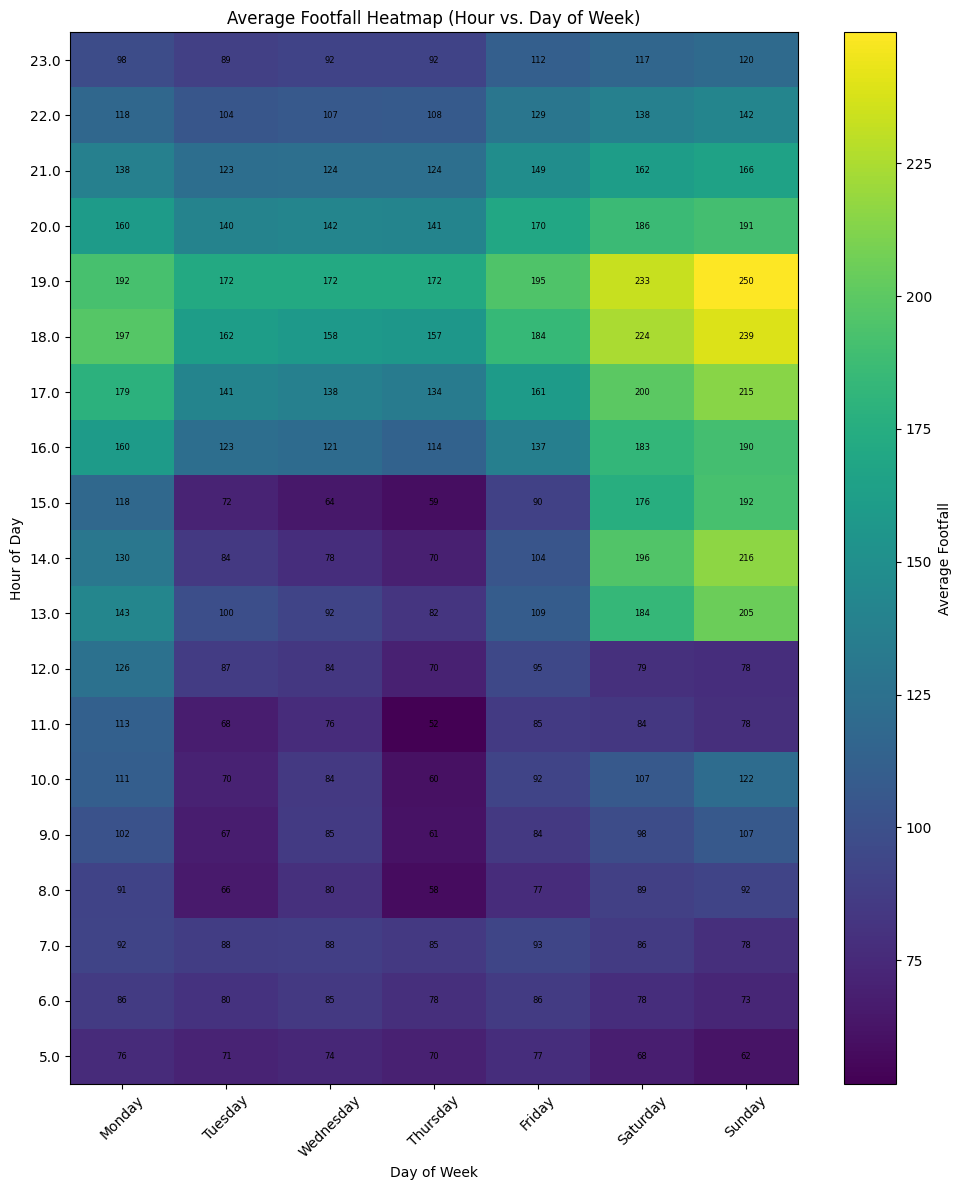

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = r"C:\Users\zaidb\Downloads\footfall_data (4).csv"

# Load & parse datetime
df = pd.read_csv(file_path, parse_dates=['datetime'], dayfirst=True)

# Extract weekday (0=Mon … 6=Sun) and hour
df['day_of_week'] = df['datetime'].dt.dayofweek
df['hour'] = df['datetime'].dt.hour

# Filter to hours 5–23
df = df[df['hour'].between(5, 23)]

# Compute average footfall per hour per weekday
heatmap_data = df.groupby(['hour', 'day_of_week'])['footfall'] \
                 .mean() \
                 .unstack()

# Plot heatmap
fig, ax = plt.subplots(figsize=(10, 12))
im = ax.imshow(heatmap_data.values, aspect='auto', origin='lower')

# Axis ticks
ax.set_xticks(range(7))
ax.set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], rotation=45)
ax.set_yticks(range(len(heatmap_data.index)))
ax.set_yticklabels(heatmap_data.index)

# Annotate each cell
for i in range(heatmap_data.shape[0]):
    for j in range(heatmap_data.shape[1]):
        ax.text(j, i, f"{heatmap_data.iat[i, j]:.0f}", ha='center', va='center', fontsize=6)

ax.set_xlabel('Day of Week')
ax.set_ylabel('Hour of Day')
ax.set_title('Average Footfall Heatmap (Hour vs. Day of Week)')

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Average Footfall')

plt.tight_layout()
plt.show()


Epoch 1/20
33/33 [==============================] - 6s 49ms/step - loss: 0.0537 - val_loss: 0.0278
Epoch 2/20
33/33 [==============================] - 0s 14ms/step - loss: 0.0290 - val_loss: 0.0228
Epoch 3/20
33/33 [==============================] - 0s 9ms/step - loss: 0.0239 - val_loss: 0.0174
Epoch 4/20
33/33 [==============================] - 0s 10ms/step - loss: 0.0163 - val_loss: 0.0127
Epoch 5/20
33/33 [==============================] - 0s 10ms/step - loss: 0.0136 - val_loss: 0.0127
Epoch 6/20
33/33 [==============================] - 0s 10ms/step - loss: 0.0129 - val_loss: 0.0115
Epoch 7/20
33/33 [==============================] - 0s 10ms/step - loss: 0.0123 - val_loss: 0.0106
Epoch 8/20
33/33 [==============================] - 0s 10ms/step - loss: 0.0114 - val_loss: 0.0096
Epoch 9/20
33/33 [==============================] - 0s 10ms/step - loss: 0.0109 - val_loss: 0.0100
Epoch 10/20
33/33 [==============================] - 0s 11ms/step - loss: 0.0113 - val_loss: 0.0091
Epoch 11/2

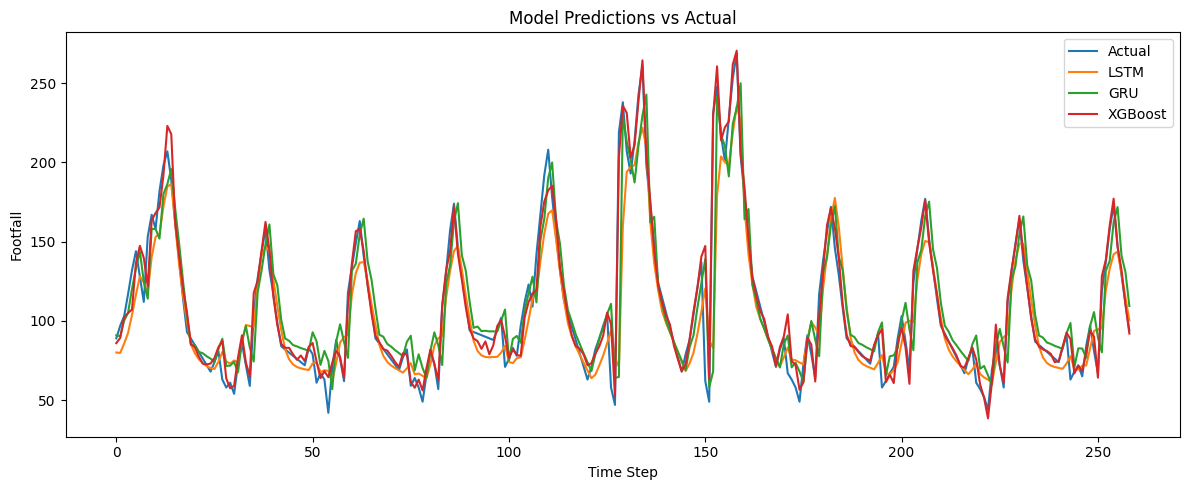

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Load and prepare data
def load_data(path):
    df = pd.read_csv(path, parse_dates=['datetime'], dayfirst=True)
    df.set_index('datetime', inplace=True)
    df = df.resample('H').mean()  # Ensure hourly frequency
    df['footfall'].interpolate(inplace=True)
    return df

file_path = r"C:\Users\zaidb\Downloads\footfall_data (4).csv"
df = load_data(file_path)

# Scale values
scaler = MinMaxScaler()
values = df['footfall'].values.reshape(-1, 1)
scaled = scaler.fit_transform(values)

# Create supervised dataset (24-hour lookback)
def create_sequences(data, n_steps=24):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

n_steps = 24
X, y = create_sequences(scaled, n_steps)

# Split train/test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for RNNs
X_train_rnn = X_train.reshape((X_train.shape[0], n_steps, 1))
X_test_rnn = X_test.reshape((X_test.shape[0], n_steps, 1))

# Build models
def build_lstm():
    model = Sequential([LSTM(50, input_shape=(n_steps, 1)), Dense(1)])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru():
    model = Sequential([GRU(50, input_shape=(n_steps, 1)), Dense(1)])
    model.compile(optimizer='adam', loss='mse')
    return model

# Train LSTM
lstm = build_lstm()
lstm.fit(X_train_rnn, y_train, epochs=20, batch_size=32, validation_data=(X_test_rnn, y_test))

# Train GRU
gru = build_gru()
gru.fit(X_train_rnn, y_train, epochs=20, batch_size=32, validation_data=(X_test_rnn, y_test))

# Train XGBoost (flatten inputs)
X_train_xgb = X_train.reshape(X_train.shape[0], -1)
X_test_xgb = X_test.reshape(X_test.shape[0], -1)
xgb = XGBRegressor(n_estimators=100)
xgb.fit(X_train_xgb, y_train)

# Predictions
preds_lstm = scaler.inverse_transform(lstm.predict(X_test_rnn))
preds_gru = scaler.inverse_transform(gru.predict(X_test_rnn))
preds_xgb = scaler.inverse_transform(xgb.predict(X_test_xgb).reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate
for name, pred in [('LSTM', preds_lstm), ('GRU', preds_gru), ('XGBoost', preds_xgb)]:
    rmse = np.sqrt(mean_squared_error(y_test_inv, pred))
    print(f"{name} RMSE: {rmse:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label='Actual')
plt.plot(preds_lstm, label='LSTM')
plt.plot(preds_gru, label='GRU')
plt.plot(preds_xgb, label='XGBoost')
plt.xlabel('Time Step')
plt.ylabel('Footfall')
plt.title('Model Predictions vs Actual')
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
!pip install scikit-learn



  Using cached scikit_learn-1.3.2-cp38-cp38-win_amd64.whl.metadata (11 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.3.2-cp38-cp38-win_amd64.whl (9.3 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)


In [8]:
!pip install xgboost 


  Using cached xgboost-2.1.4-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-2.1.4-py3-none-win_amd64.whl (124.9 MB)


In [6]:
# Use the magic %pip so it installs into the same kernel
%pip install --upgrade tensorflow



  Using cached tensorflow-2.13.1-cp38-cp38-win_amd64.whl.metadata (2.6 kB)
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
  Using cached tensorboard-2.13.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached tensorflow_estimator-2.13.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached google_auth_oauthlib-1.0.0-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
Using cached tensorboard-2.13.0-py3-none-any.whl (5.6 MB)
Using cached tensorflow_estimator-2.13.0-py2.py3-none-any.whl (440 kB)
Using cached google_auth_oauthlib-1.0.0-py2.py3-none-any.whl (18 kB)
Using cached tensorboard_data_server-0.7.2-py3-none-any.whl (2.4 kB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.10.0
    Uninstalling tensorflow-estimator-2.10.0:
      Successfully uninstalled tensorflow-esti

In [ ]:
!pip install xgboost



In [10]:
# Simple ensemble: average the three model predictions
preds_ensemble = (preds_lstm + preds_gru + preds_xgb) / 3

# Compute RMSE on the inverse‑scaled test set
from sklearn.metrics import mean_squared_error
import numpy as np

rmse_ensemble = np.sqrt(mean_squared_error(y_test_inv, preds_ensemble))
print(f"Ensemble RMSE: {rmse_ensemble:.2f}")


Ensemble RMSE: 15.75


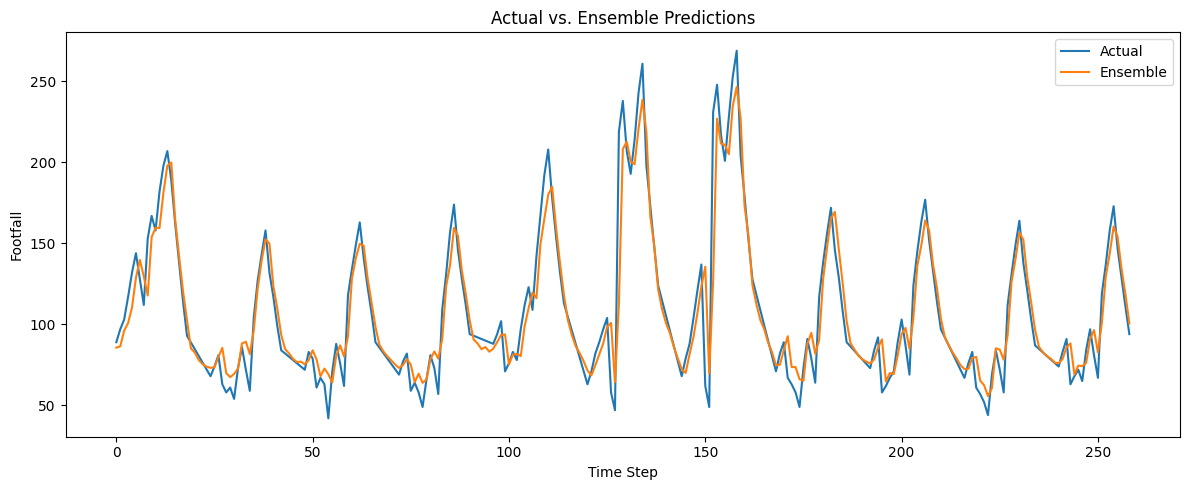

In [11]:
# Compute ensemble predictions (if not already done)
preds_ensemble = (preds_lstm + preds_gru + preds_xgb) / 3

# Plot Actual vs. Ensemble predictions
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label='Actual')
plt.plot(preds_ensemble, label='Ensemble')
plt.xlabel('Time Step')
plt.ylabel('Footfall')
plt.title('Actual vs. Ensemble Predictions')
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
from sklearn.metrics import mean_absolute_percentage_error

# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test_inv, preds_ensemble)

# Convert MAPE to “accuracy” (%) 
accuracy = 100 * (1 - mape)

print(f"Ensemble Accuracy: {accuracy:.2f}%")


Ensemble Accuracy: 89.57%


In [13]:
import pandas as pd
import numpy as np

# Assuming lstm, gru, xgb, df, and scaler are defined outside this function
def predict_ensemble_for_datetime(dt_str):
    target = pd.to_datetime(dt_str, dayfirst=True)
    last_timestamp = df.index[-1]
    hours_ahead = int((target - last_timestamp) / pd.Timedelta(hours=1))

    # If the requested datetime is already in the dataset
    if hours_ahead <= 0:
        return float(df.loc[target, 'footfall'])

    # Start from the last 24‑hour sequence (scaled)
    seq = scaler.transform(df['footfall'].iloc[-n_steps:].values.reshape(-1, 1)).flatten()

    for _ in range(hours_ahead):
        inp_rnn = seq[-n_steps:].reshape(1, n_steps, 1)
        inp_xgb = seq[-n_steps:].reshape(1, n_steps)

        p_lstm = lstm.predict(inp_rnn)
        p_gru  = gru.predict(inp_rnn)
        p_xgb  = xgb.predict(inp_xgb).reshape(1, 1)

        next_scaled = (p_lstm + p_gru + p_xgb) / 3
        seq = np.append(seq, next_scaled.flatten()[0])

    return float(scaler.inverse_transform([[seq[-1]]])[0][0])

# Example usage
print(predict_ensemble_for_datetime("29-03-2025 06:00"))


1/1 [==============================] - 0s 50ms/step
86.0195198059082
